# VEME Workshop 2024 - Single cell transcriptomics

## Practice 2 - Gene Marker Discovery with NS-Forest Cell Cluster Annotation and Downstream Analyses 

## Introduction

We are continuing on with Practice 2. In the previous session, we conducted Quality Control, Integration, Dimension Reduction and Clustering. In this seesion, we will be generating marker genes for our clusters which will be used for cell type annotation. We will also be conducting some downstream analysis such as Differetial Gene Expression analysis and cell type population comparison across conditions.

In [4]:
# import necessary libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

#### 2.1 Using NS-Forest to get marker genes

We will be using NS-Forest, a random forest classification algorithm that is capable of delineating cell type cluster from one another based on the specificity of expression of a gene or a combinatorial set of genes within that cluster. This will be helpful in determining what cell type each cluster corresponds to. Generally, this is a time consuming an laborious process that requires not only good computationally derived marker genes (i.e. genes or gene sets that do well in specifying one cell type from another) but also domain knowledge and expertise to inform the process of cell type cluster annotation.  

In [5]:
adata = sc.read('data_2/GSE171524_clustered.h5ad')

In [6]:
# calling the adata object to see what it looks like before running NS-Forest
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

##### 2.1.1 Setting up necessary modules and variables

In [7]:
import nsforest as ns
from nsforest import preprocessing as pp
from nsforest import nsforesting
from nsforest import plotting as pl

In [8]:
cluster_header = 'leiden_main'
output_folder = 'nsf_output/'

In [9]:
# ensuring that adata.var_names/adata.var.index contain gene symbols rather than ensembl ID's
adata.var.index

Index(['AL627309.1', 'AL627309.5', 'AL627309.4', 'AL669831.2', 'LINC01409',
       'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'AL645608.6',
       ...
       'TRAV12-1', 'AL162726.4', 'AC069503.4', 'TRDV1', 'RIMBP3', 'AL360013.3',
       'CCDC140', 'AL109807.1', 'AC105924.1', 'AC005160.1'],
      dtype='object', length=31332)

##### 2.1.2 Preprocessing for NS-Forest

This function creates a dendrogram which displays the relatedness of each cluster based on their transciptomic profiles. We will run this function again once we have annotated our clusters to get a meaningful representation of 
the relationships between these cell types.

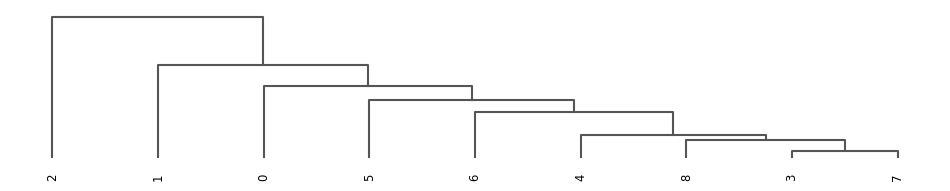

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap', 'dendrogram_leiden_main'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
ns.pp.dendrogram(adata, cluster_header, save = True, output_folder = output_folder, outputfilename_suffix= 'leiden_main')

`pp.prep_medians` function calculates the median expression of each gene in the dataset - this is used to determine the expression patterns of each gene. This is necessary for the next step.

In [11]:
adata = ns.pp.prep_medians(adata, cluster_header, positive_genes_only=False)

Calculating medians...


Calculating medians (means) per cluster: 100%|██████████| 9/9 [01:30<00:00, 10.00s/it]

Saving calculated medians as adata.varm.medians_leiden_main
--- 90.58931994438171 seconds ---
median: 0.0
mean: 0.0053530647
std: 0.24202111


The `pp.prep_binary_scores` function determines the expression pattern of each gene based on the median expression which was calculated in the previous function, particularly, it determines if a gene has a "binary expression" pattern, i.e. a gene is "on" if it has a signifigantly higher expression when comapred to all other genes. Each gene is given a 'binary_score' which calculates how well that expression pattern is seen in that gene.

In [12]:
adata = ns.pp.prep_binary_scores(adata, cluster_header)

Calculating binary scores...


Calculating binary scores per cluster: 100%|██████████| 9/9 [01:42<00:00, 11.39s/it]


Saving calculated binary scores as adata.varm.binary_scores_leiden_main
--- 103.02245998382568 seconds ---
median: 0.0
mean: 0.002661079325977526
std: 0.04876273646453983


In [13]:
# take notice of the added 'medians_leiden_main' and 'binary_scores_leiden_main' 
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap', 'dendrogram_leiden_main'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs', 'medians_leiden_main', 'binary_scores_leiden_main'
    obsp: 'connectivities', 'distances'

##### 2.1.3 Running NS-Forest

Now, we are going to run the main NS-Forest algorithm. The marker and top-ranked binary genes that are derived from this algorithm will be used to identify the cell types.

In [15]:
main_results = nsforesting.NSForest(adata, cluster_header, output_folder = output_folder, outputfilename_prefix = 'leiden_main')

Preparing adata...
--- 0.009991884231567383 seconds ---
Pre-selecting genes based on binary scores...
	 Threshold (mean + 2 * std): 0.10018655225505718
	Average number of genes after gene_selection in each cluster: 100.22222222222223
Number of clusters to evaluate: 9
1 out of 9:
	0
	 Pre-selected 112 genes to feed into Random Forest.
	['CTSB']
	fbeta: 0.8457690876772354
	PPV: 0.9103448275862069
	recall: 0.658831106102077
2 out of 9:
	1
	 Pre-selected 84 genes to feed into Random Forest.
	['LAMA2']
	fbeta: 0.9022098857691897
	PPV: 0.9397309018125208
	recall: 0.7779618889809445
3 out of 9:
	2
	 Pre-selected 110 genes to feed into Random Forest.
	['SFTPB']
	fbeta: 0.8973912639836605
	PPV: 0.9320236229962637
	recall: 0.7812689432208527
4 out of 9:
	3
	 Pre-selected 43 genes to feed into Random Forest.
	['SKAP1', 'FYN']
	fbeta: 0.800067303243175
	PPV: 0.9175108538350217
	recall: 0.5291417443316178
5 out of 9:
	4
	 Pre-selected 67 genes to feed into Random Forest.
	['LDB2', 'PECAM1']
	fbeta:

Calculating medians (means) per cluster: 100%|██████████| 9/9 [00:00<00:00, 54.39it/s]

Saving final results table as...
nsf_output/leiden_main_results.csv
--- 296.0315971374512 seconds ---


In [16]:
# take a look at the NS-Forest results
main_results

,clusterName,clusterSize,f_score,PPV,recall,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes,onTarget
0,0,12422,0.845769,0.910345,0.658831,36428,806,4238,8184,1,[CTSB],"[SLC11A1, CTSB, CD163, SLC8A1, KYNU, MRC1, KCN...",0.913103
1,1,10863,0.902210,0.939731,0.777962,38251,542,2412,8451,1,[LAMA2],"[LAMA2, CACNA1C, COL1A2, COL6A3, LSAMP, COL3A1...",0.928310
2,2,9898,0.897391,0.932024,0.781269,39194,564,2165,7733,1,[SFTPB],"[SFTPB, SFTA3, ATP13A4, GPC5, ZNF385B, ADGRV1,...",0.958210
3,3,7189,0.800067,0.917511,0.529142,42125,342,3385,3804,2,"[SKAP1, FYN]","[SKAP1, THEMIS, FYN, ETS1, PARP8, IKZF1, CNOT6...",0.563822
4,4,3446,0.761366,0.925769,0.445154,46087,123,1912,1534,2,"[LDB2, PECAM1]","[LDB2, CALCRL, ST6GALNAC3, PECAM1, GALNT18, DO...",0.768178
5,5,3371,0.760437,0.986716,0.396618,46267,18,2034,1337,2,"[IFNG-AS1, TXNDC5]","[IFNG-AS1, TXNDC5, RALGPS2, DENND5B, SEL1L3, F...",0.919121
6,6,936,0.949541,0.967290,0.884615,48692,28,108,828,1,[DNAH12],"[DNAH12, CFAP299, CFAP47, DNAH9, SPAG17, ZBBX,...",0.996255
7,7,784,0.820552,0.938596,0.545918,48844,28,356,428,2,"[KIT, SLC24A3]","[KIT, CPA3, SLC24A3, IL18R1, BMP2K, SYTL3, AL3...",0.916567
8,8,747,0.786517,0.990769,0.431058,48906,3,425,322,2,"[CEACAM5, RGS6]","[CEACAM5, GNGT1, LINC00342, RGS6, PTPRN2, ANKR...",0.941779


The table above details the selected marker genes(`NSForest_markers`) and top-ranked binary genes(`binary_genes`) from NS-Forest. It also includes classification metrics such as Fβ score(`f_score`), recall, Positive Predictive Value(`PPV`) and the `onTarget` score. Recall measures the completeness of positive predictions - when looking at all actual positive cases (i.e. True and False Negatives), recall measures how well True Positives were classified as such. PPV is precision, which measures how accurate the positive predictions are - of all cases labeled as positive (i.e. True and False Positives), precision measures the proportion of these cases that are truly positive. Recall and PPV are used to calculate the Fβ score, which essentially indicates the specificity of the selected marker gene(s) to that cluster. The onTarget score also indicates the specificity of expression of marker genes in a cluster, by divding the median expression of markers in one cluster by the median expression of that marker in all off-target clusters. 

##### 2.1.3 Plotting classification metrics

In [ ]:
ns.pl.boxplot(main_results, 'f_score')

In [ ]:
ns.pl.boxplot(main_results, 'recall')

In [ ]:
ns.pl.boxplot(main_results, 'PPV')

The boxplots above display the distributions of each classification metric across all of the clusters. As we can see, these metrics are quite high, indicating the specifity of the selected marker genes by NS-Forest. Given that we are working with pretty broad classifications for cell types, it makes sense why the metrics are relatively high. These values will more than likely decrease with increased granularity of cell type clusters.

#### 2.2 Cluster cell type annotation

Now that we have our marker genes for each of our clusters, we can now identify the cell types for each. This is where domain expertise is critical in order to obtain proper annotation of the cell types/states. To save time, there is already a dictionary, `cluster_membership`, that shows the label given by the leiden algorithm and which cell type it corresponds to. We will also take a look at these markers and cross reference them with the original dataset on the CellxGene platform.

*note: might swap around dictionary annotation with cxg x-ref just in case cell type clusters are not appropriately reproduced

In [ ]:
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap', 'dendrogram_leiden_main'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs', 'medians_leiden_main', 'binary_scores_leiden_main'
    obsp: 'connectivities', 'distances'

##### 2.2.1 Cross referencing NS-Forest markers with original data in CellxGene for annotation

In this step, we will be using [CellxGene](https://cellxgene.cziscience.com/), a portal used to visualize and analyze already processed and annotated scRNA-seq data. The original data set from this study is hosted on this platform. 

The data can be found in the following link: https://cellxgene.cziscience.com/collections/e4c9ed14-e560-4900-a3bf-b0f8d2ce6a10.

#### 1. Click the Explore button.

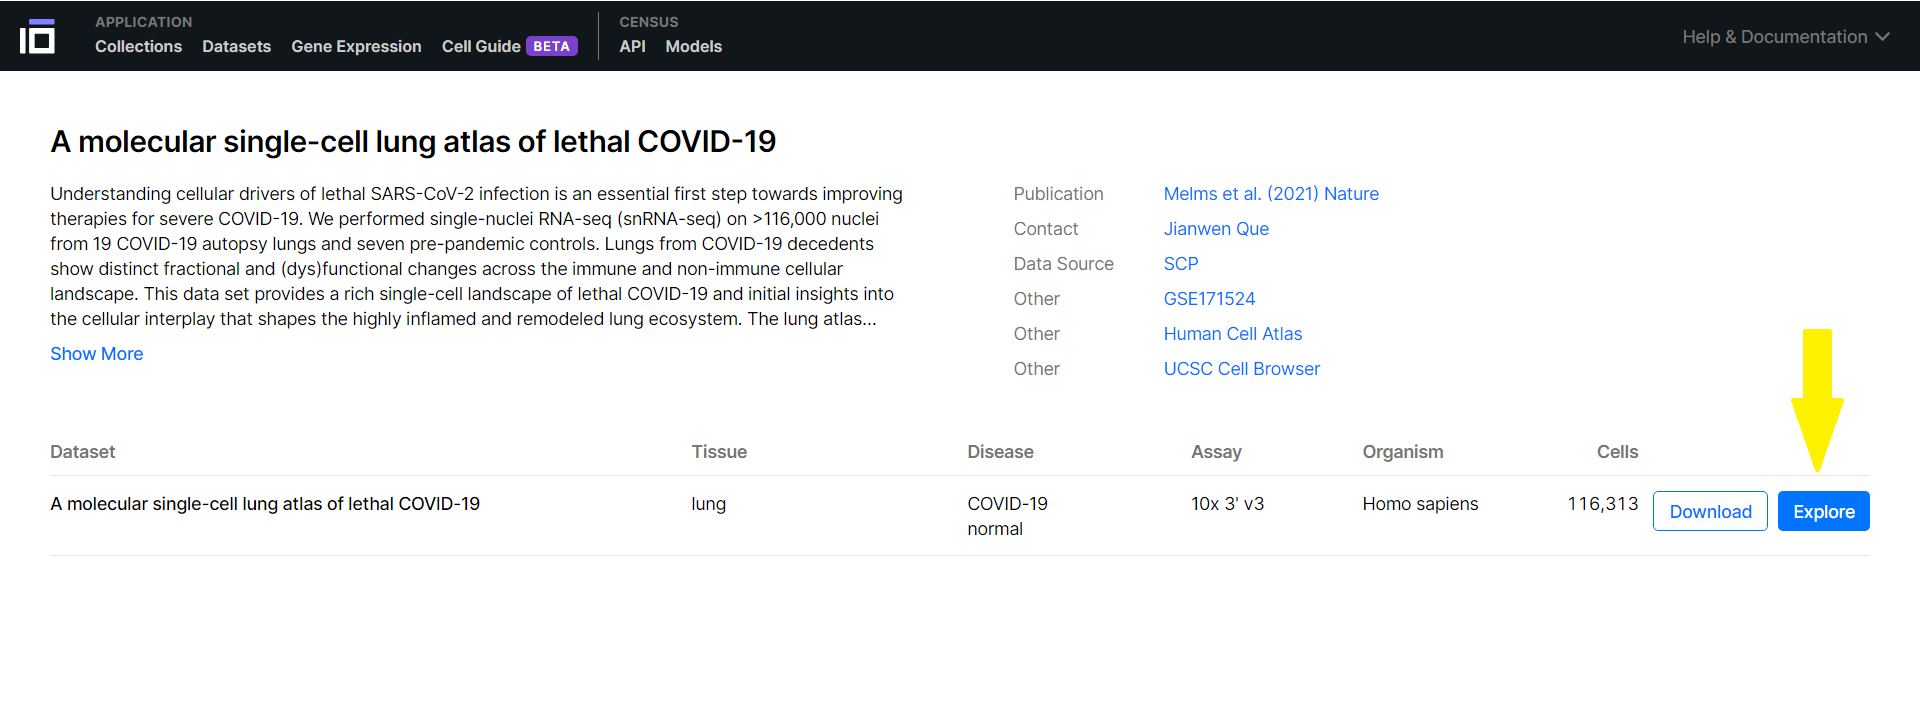

#### 2. Next you will be greeted with the following interface. Take notice of the 'Create New' button:

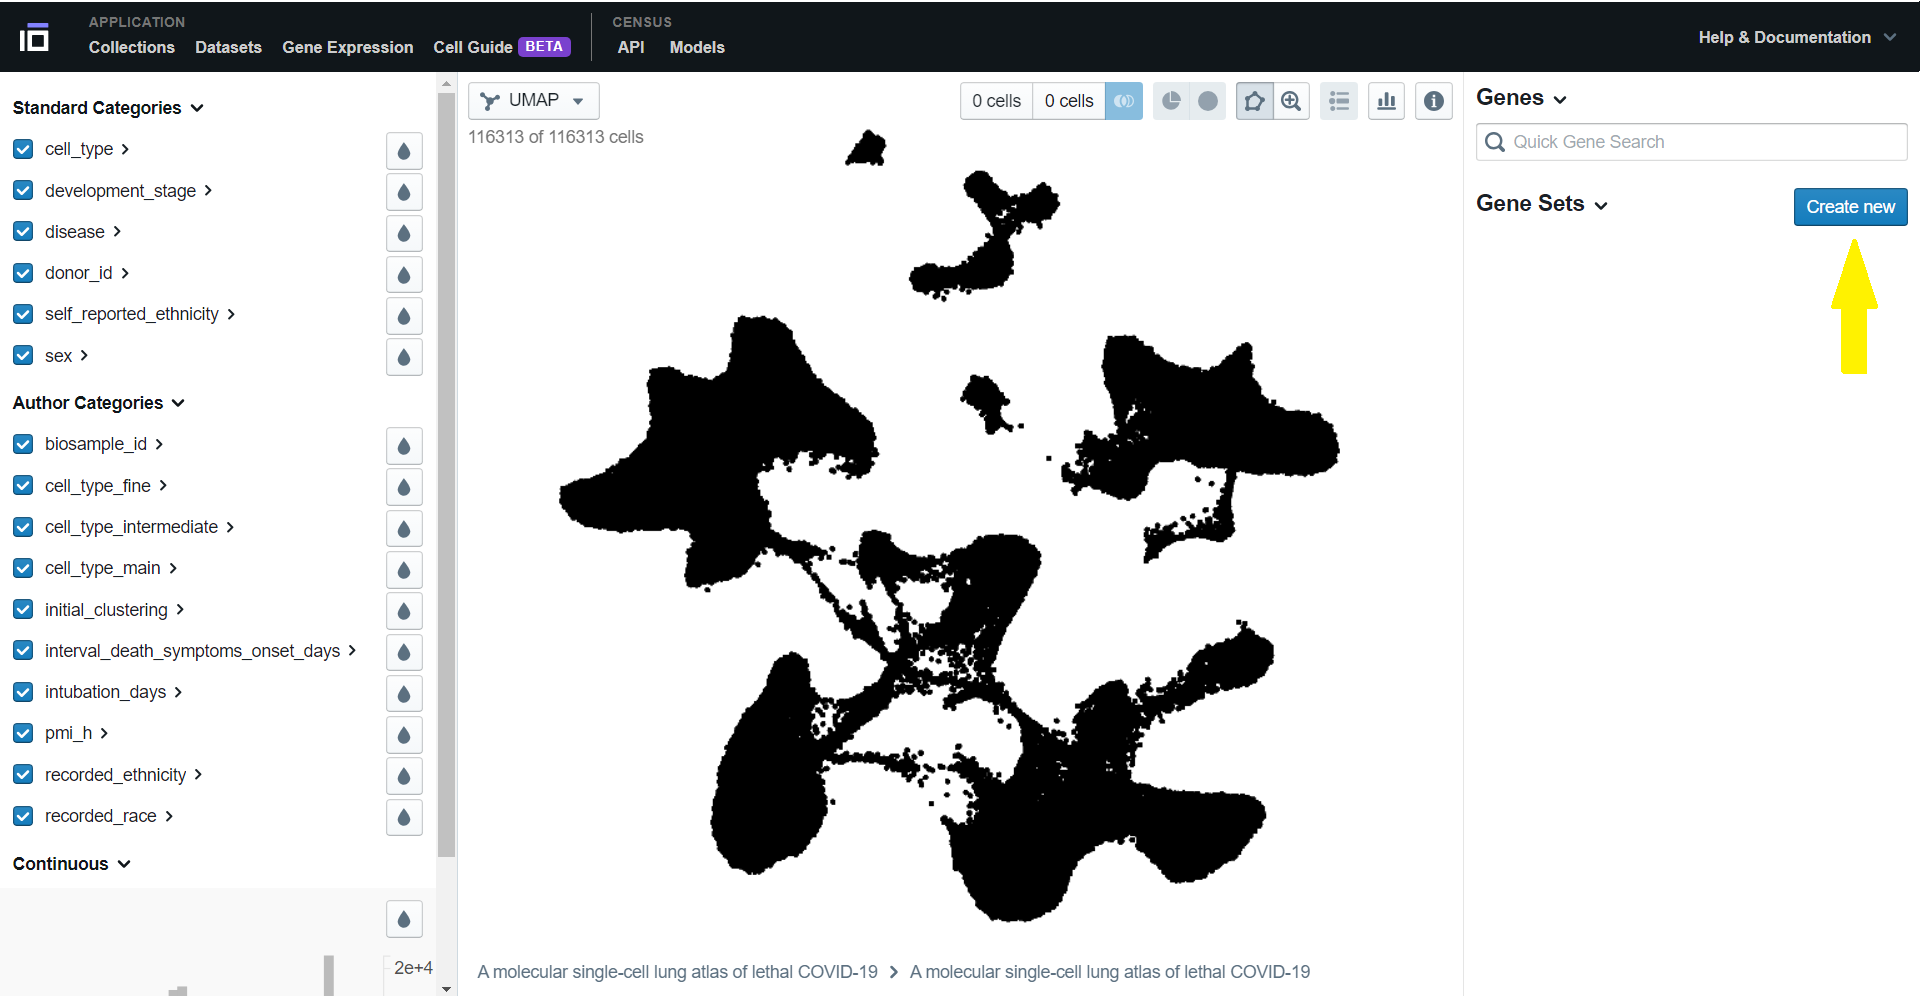

#### 3. We will be creating gene sets for some of the cluster using some of the binary genes, click the 'create new' button and you will see the following box. Here you can name the gene set name and insert which genes you would like. Let's try it for cluster 0:

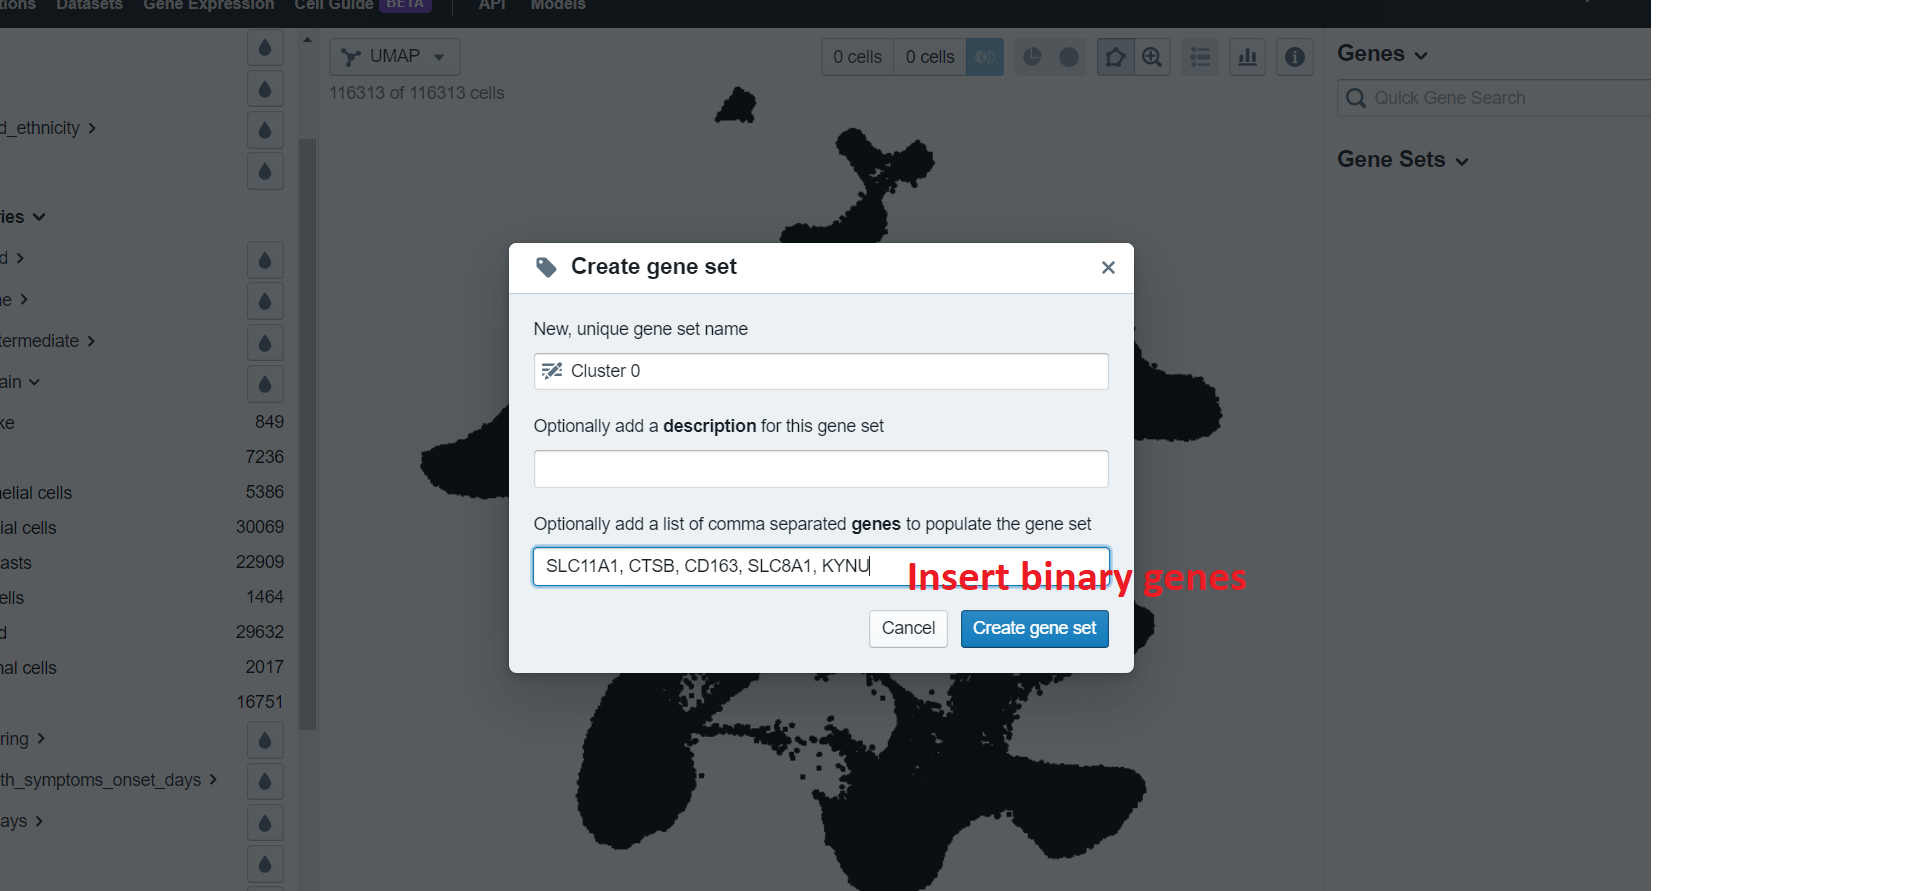

#### 4. Now we look at the results. It seems as though Cluster 0 corresponds to Myeloid cells:

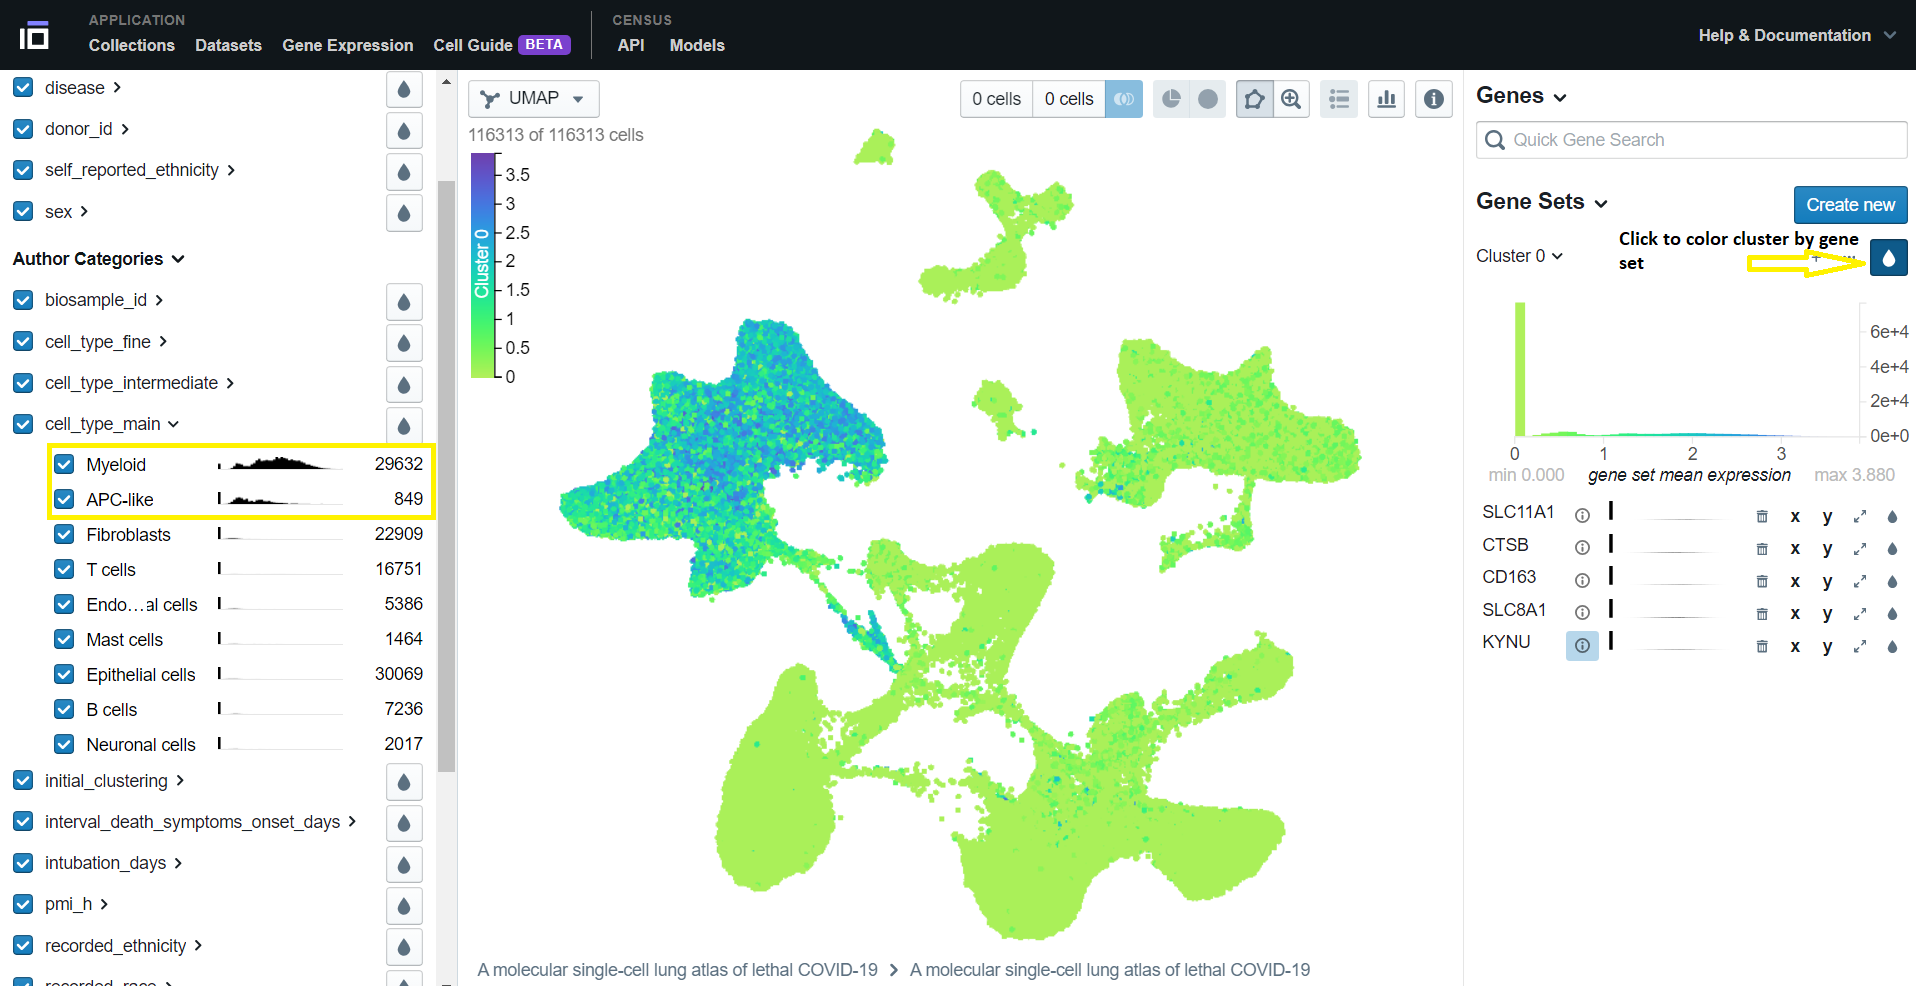

#### Now give it a shot with your cell type clusters. The results you have obtained from NS-Forest will differ from others, so the annotation will need to be specific to your results. There is a dictionary below that contains cluster annotations, **but these will need to be rearranged for your respective results**. 

In the Melms *et al.* paper, they reported 9 cell types for their 'cell_type_main' annotation level - Myeloid cells, APC-like cells, Fibroblasts, T cells, Endothelial cells, Mast cells, Epithelial cells, B/Plasma cells, and Neuronal cells. It is important to note that come of these cell types may not be recapitulated in this downsampled dataset since some cell type populations are inncredibly small when compared to other cell types (ex. Mast cells, Neuronal cells, APC-like cells).

In [17]:
# change cluster annotations in dictionary to match with your own
cluster_membership = {
    '0' : 'Myeloid cells',
    '1' : 'Fibroblasts',
    '2' : 'Alveolar epithelial cells',
    '3' : 'T/NK cells',
    '4' : 'Endothelial cells',
    '5' : 'B/Plasma cells',
    '6' : 'Airway epithelial cells',
    '7' : 'Mast cells',
    '8' : 'Other epithelial cells'
}

##### 2.2.2 Mapping annotations to clusters

In [18]:
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap', 'dendrogram_leiden_main'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs', 'medians_leiden_main', 'binary_scores_leiden_main'
    obsp: 'connectivities', 'distances'

In [19]:
adata.obs['cell_type'] = adata.obs.leiden_main.map(cluster_membership)

In [20]:
# take notice of the added `cell_type` column
adata.obs

,group,donor,treatment,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden_intermediate,leiden_main,leiden_fine,cell_type
GACTGATAGCATACTC-1_13-12-0,L06cov,L06cov,COVID-19,0,1844,3136.0,38.0,1.211735,9.0,0.286990,0,0,4,Myeloid cells
TCGGATAGTCCAGAAG-1_13-12-0,L06cov,L06cov,COVID-19,0,1874,3475.0,4.0,0.115108,50.0,1.438849,6,5,7,B/Plasma cells
AGGTGTTGTGCCTTCT-1_13-12-0,L06cov,L06cov,COVID-19,0,1758,2927.0,0.0,0.000000,48.0,1.639904,5,4,6,Endothelial cells
TCAGCAATCATCTACT-1_13-12-0,L06cov,L06cov,COVID-19,0,622,798.0,5.0,0.626566,16.0,2.005013,12,1,12,Fibroblasts
GTGGCGTGTTAGTTCG-1_13-12-0,L06cov,L06cov,COVID-19,0,571,710.0,6.0,0.845070,9.0,1.267606,2,3,10,T/NK cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAACCTCGTTCAGCTA-1_17-16-26,L10cov,L10cov,COVID-19,26,1180,1868.0,0.0,0.000000,2.0,0.107066,4,2,5,Alveolar epithelial cells
CATACAGCATACTGTG-1_17-16-26,L10cov,L10cov,COVID-19,26,1460,2209.0,0.0,0.000000,0.0,0.000000,7,1,8,Fibroblasts
TCATGGAAGCTACTAC-1_17-16-26,L10cov,L10cov,COVID-19,26,420,517.0,2.0,0.386847,0.0,0.000000,0,0,4,Myeloid cells
TCGCAGGCAACCAACT-1_17-16-26,L10cov,L10cov,COVID-19,26,1270,2096.0,0.0,0.000000,1.0,0.047710,1,1,0,Fibroblasts


##### 2.2.3 Preparing the data for plotting

The dendrogram created will be necessary for plotting steps ahead. 

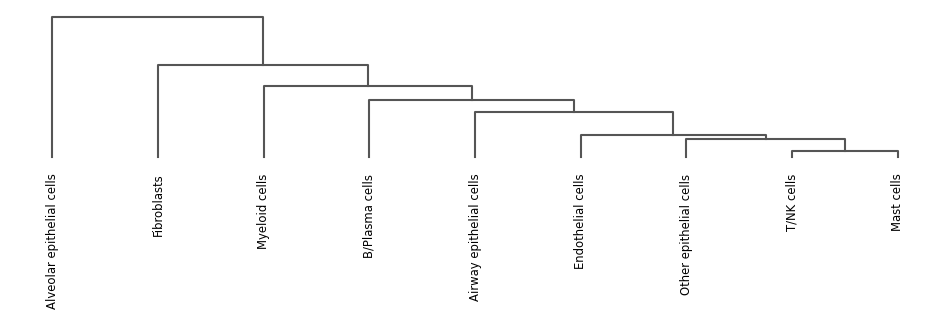

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine', 'cell_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap', 'dendrogram_leiden_main', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs', 'medians_leiden_main', 'binary_scores_leiden_main'
    obsp: 'connectivities', 'distances'

In [21]:
ns.pp.dendrogram(adata, cluster_header = 'cell_type', save = True, output_folder = output_folder, outputfilename_suffix= 'cell_type')

In [22]:
# notice the added `dendrogram_cell_type` in adata.uns
adata

AnnData object with n_obs × n_vars = 49656 × 31332
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden_intermediate', 'leiden_main', 'leiden_fine', 'cell_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'group_colors', 'leiden_fine', 'leiden_fine_colors', 'leiden_intermediate', 'leiden_intermediate_colors', 'leiden_main', 'leiden_main_colors', 'neighbors', 'pca', 'umap', 'dendrogram_leiden_main', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs', 'medians_leiden_main', 'binary_scores_leiden_main'
    obsp: 'connectivities', 'distances'

In [23]:
dendrogram = list(adata.uns['dendrogram_cell_type']['categories_ordered'])
dendrogram

['Alveolar epithelial cells',
 'Fibroblasts',
 'Myeloid cells',
 'B/Plasma cells',
 'Airway epithelial cells',
 'Endothelial cells',
 'Other epithelial cells',
 'T/NK cells',
 'Mast cells']

In [24]:
# correcting NS-Forest results dataframe to include cluster names. This dataframe is being prepared to make a cell type : marker(s) dictionary for plotting
to_plot = main_results.copy()
to_plot['clusterName'] = to_plot['clusterName'].map(cluster_membership)
to_plot['clusterName'] = to_plot['clusterName'].astype("category")
to_plot

,clusterName,clusterSize,f_score,PPV,recall,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes,onTarget
0,Myeloid cells,12422,0.845769,0.910345,0.658831,36428,806,4238,8184,1,[CTSB],"[SLC11A1, CTSB, CD163, SLC8A1, KYNU, MRC1, KCN...",0.913103
1,Fibroblasts,10863,0.902210,0.939731,0.777962,38251,542,2412,8451,1,[LAMA2],"[LAMA2, CACNA1C, COL1A2, COL6A3, LSAMP, COL3A1...",0.928310
2,Alveolar epithelial cells,9898,0.897391,0.932024,0.781269,39194,564,2165,7733,1,[SFTPB],"[SFTPB, SFTA3, ATP13A4, GPC5, ZNF385B, ADGRV1,...",0.958210
3,T/NK cells,7189,0.800067,0.917511,0.529142,42125,342,3385,3804,2,"[SKAP1, FYN]","[SKAP1, THEMIS, FYN, ETS1, PARP8, IKZF1, CNOT6...",0.563822
4,Endothelial cells,3446,0.761366,0.925769,0.445154,46087,123,1912,1534,2,"[LDB2, PECAM1]","[LDB2, CALCRL, ST6GALNAC3, PECAM1, GALNT18, DO...",0.768178
5,B/Plasma cells,3371,0.760437,0.986716,0.396618,46267,18,2034,1337,2,"[IFNG-AS1, TXNDC5]","[IFNG-AS1, TXNDC5, RALGPS2, DENND5B, SEL1L3, F...",0.919121
6,Airway epithelial cells,936,0.949541,0.967290,0.884615,48692,28,108,828,1,[DNAH12],"[DNAH12, CFAP299, CFAP47, DNAH9, SPAG17, ZBBX,...",0.996255
7,Mast cells,784,0.820552,0.938596,0.545918,48844,28,356,428,2,"[KIT, SLC24A3]","[KIT, CPA3, SLC24A3, IL18R1, BMP2K, SYTL3, AL3...",0.916567
8,Other epithelial cells,747,0.786517,0.990769,0.431058,48906,3,425,322,2,"[CEACAM5, RGS6]","[CEACAM5, GNGT1, LINC00342, RGS6, PTPRN2, ANKR...",0.941779


In [25]:
markers_dict = dict(zip(to_plot['clusterName'], to_plot['NSForest_markers']))
markers_dict

{'Myeloid cells': ['CTSB'],
 'Fibroblasts': ['LAMA2'],
 'Alveolar epithelial cells': ['SFTPB'],
 'T/NK cells': ['SKAP1', 'FYN'],
 'Endothelial cells': ['LDB2', 'PECAM1'],
 'B/Plasma cells': ['IFNG-AS1', 'TXNDC5'],
 'Airway epithelial cells': ['DNAH12'],
 'Mast cells': ['KIT', 'SLC24A3'],
 'Other epithelial cells': ['CEACAM5', 'RGS6']}

##### 2.1.3 Creating the dotplot and matrix plot
Now that we know what cell type each of our clusters correspond to, and our data is prepared, we can now create plots to display the specificity of expression of the NS-Forest markers for each of the clusters.

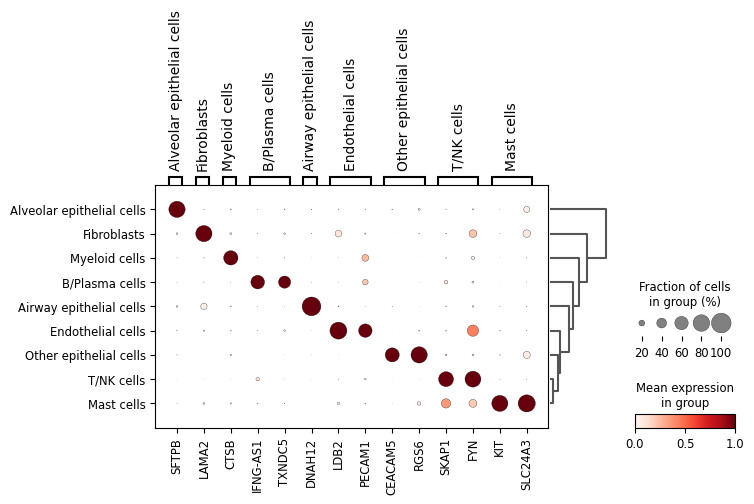

In [26]:
ns.pl.dotplot(adata, markers_dict, cluster_header = 'cell_type', dendrogram = True, save = True, output_folder = output_folder, outputfilename_suffix = 'cell_type_main')

The figure above is a dotplot displaying the NS-Forest generated markers on the x-axis and the cell types on the y-axis. The labelling across the top horizontal axis displays the cell type that each gene or set of genes belong to. The size of each dot indicates the fraction of cells in that cell type cluster that express a given gene. The color of the dot indicates the mean expression of that marker genes within a given group. The diagonal, step pattern that we see in the dotplot indicates that these markers are very specific for the annotated cell types, with there being very little off target expression seen in other cell type clusters. 

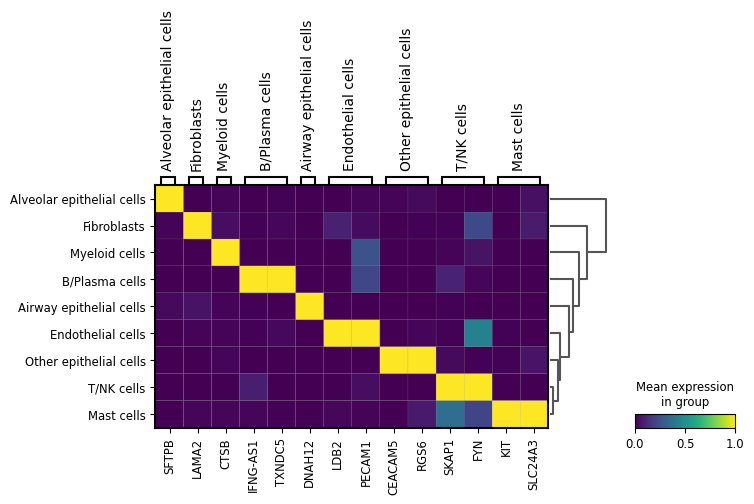

In [27]:
ns.pl.matrixplot(adata, markers_dict, cluster_header = 'cell_type', dendrogram = True, save = True, output_folder = output_folder, outputfilename_suffix = 'cell_type_main')

The matrix plot above is very similar to the previous dotplot, except it does not have the capability of providing the fraction of cells within a cell type cluster that express a given marker gene. As we can see, there is that diagonal step pattern that we are looking for to indicate the specificity of these markers for these cell types.

#### 2.3 Further Analysis

In this step, we will attempt to recreate some of the plots from the publication and conduct some downstream analysis steps. 

##### 2.3.1 Adapting Figure 2d from the publication
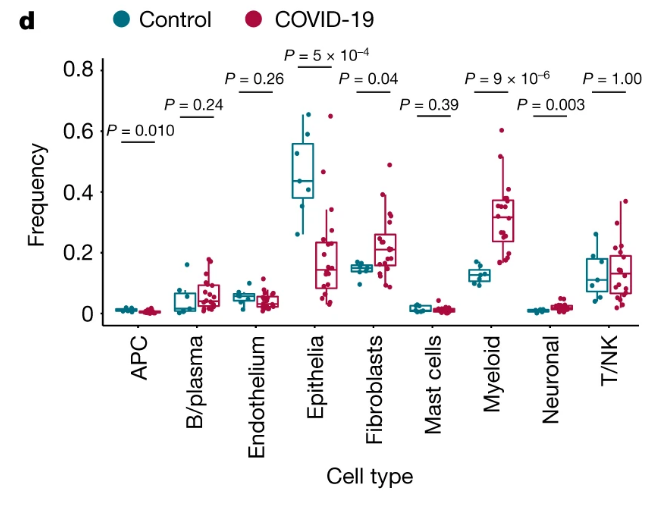

The figure above is sourced from Figure 2 in Melms *et al.*'s paper. It displays the differences in cell type distributions based on their condition. We are going to attempt to reproduce this figure in the following section.

In [28]:
# calculating the number of total cells per group
num_tot_cells = adata.obs.groupby(['group']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.donor))
num_tot_cells

/var/folders/vz/ggcbdp195vb6bwjd2hw6yfsc0000gn/T/ipykernel_7168/2060662423.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['group']).count()


{'C51ctr': 2847,
 'C52ctr': 1880,
 'C53ctr': 3101,
 'C54ctr': 1918,
 'C55ctr': 2706,
 'C56ctr': 1690,
 'C57ctr': 2235,
 'L01cov': 1342,
 'L03cov': 1654,
 'L04cov': 1622,
 'L04covaddon': 1973,
 'L05cov': 1345,
 'L06cov': 2873,
 'L07cov': 2033,
 'L08cov': 1850,
 'L09cov': 1310,
 'L10cov': 652,
 'L11cov': 1460,
 'L12cov': 1754,
 'L13cov': 2238,
 'L15cov': 1586,
 'L16cov': 704,
 'L17cov': 2184,
 'L18cov': 1276,
 'L19cov': 978,
 'L21cov': 1341,
 'L22cov': 3104}

In [29]:
# calculating the number of cells per cell type, sample, & treatment
cell_type_counts = adata.obs.groupby(['group', 'treatment', 'cell_type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts

/var/folders/vz/ggcbdp195vb6bwjd2hw6yfsc0000gn/T/ipykernel_7168/2857914512.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['group', 'treatment', 'cell_type']).count()


,group,treatment,cell_type,donor,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden_intermediate,leiden_main,leiden_fine
0,C51ctr,Control,Myeloid cells,259,259,259,259,259,259,259,259,259,259,259
1,C51ctr,Control,Fibroblasts,424,424,424,424,424,424,424,424,424,424,424
2,C51ctr,Control,Alveolar epithelial cells,845,845,845,845,845,845,845,845,845,845,845
3,C51ctr,Control,T/NK cells,749,749,749,749,749,749,749,749,749,749,749
4,C51ctr,Control,Endothelial cells,326,326,326,326,326,326,326,326,326,326,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,L22cov,COVID-19,T/NK cells,653,653,653,653,653,653,653,653,653,653,653
210,L22cov,COVID-19,Endothelial cells,122,122,122,122,122,122,122,122,122,122,122
211,L22cov,COVID-19,B/Plasma cells,296,296,296,296,296,296,296,296,296,296,296
212,L22cov,COVID-19,Airway epithelial cells,9,9,9,9,9,9,9,9,9,9,9


In [30]:
# calculating the frequency of cell types per condition (COVID-19 or Control)
cell_type_counts['total_cells'] = cell_type_counts.group.map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts.donor / cell_type_counts.total_cells
cell_type_counts

,group,treatment,cell_type,donor,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden_intermediate,leiden_main,leiden_fine,total_cells,frequency
0,C51ctr,Control,Myeloid cells,259,259,259,259,259,259,259,259,259,259,259,2847,0.090973
1,C51ctr,Control,Fibroblasts,424,424,424,424,424,424,424,424,424,424,424,2847,0.148929
2,C51ctr,Control,Alveolar epithelial cells,845,845,845,845,845,845,845,845,845,845,845,2847,0.296804
3,C51ctr,Control,T/NK cells,749,749,749,749,749,749,749,749,749,749,749,2847,0.263084
4,C51ctr,Control,Endothelial cells,326,326,326,326,326,326,326,326,326,326,326,2847,0.114506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,L22cov,COVID-19,T/NK cells,653,653,653,653,653,653,653,653,653,653,653,3104,0.210374
210,L22cov,COVID-19,Endothelial cells,122,122,122,122,122,122,122,122,122,122,122,3104,0.039304
211,L22cov,COVID-19,B/Plasma cells,296,296,296,296,296,296,296,296,296,296,296,3104,0.095361
212,L22cov,COVID-19,Airway epithelial cells,9,9,9,9,9,9,9,9,9,9,9,3104,0.002899


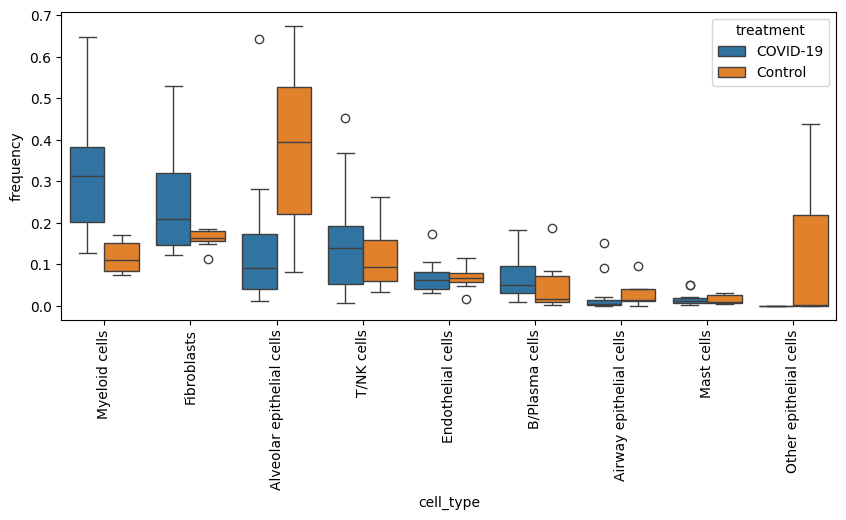

In [31]:
# plotting the cell type frequencies across conditions
plt.figure(figsize = (10,4))
ax = sns.boxplot(data = cell_type_counts, x = 'cell_type', y = 'frequency', hue = 'treatment')
plt.xticks(rotation = 90)
plt.show()

If we compare this plot to Figure 2d, we can already notice some contrasts between the two. Firstly, the cell types differ quite a bit - this can be attributed to the fact that our data is downsampled, so it is entirely possible that some cell types were greatly obscured or left out in the reduction process. Secondly, Melms *et al.* conducted a Wilcoxon rank-sum test to obtain p-values for the difference in frequencies between conditions. Other than that, this plot follows some of the trends observed in the original figure quite well. For example, we see a similarities between both figures in T/NK cells, Mast cells, Myeloid cells, etc.

##### 2.3.2 Differential Gene Expression Analysis when comparing conditions

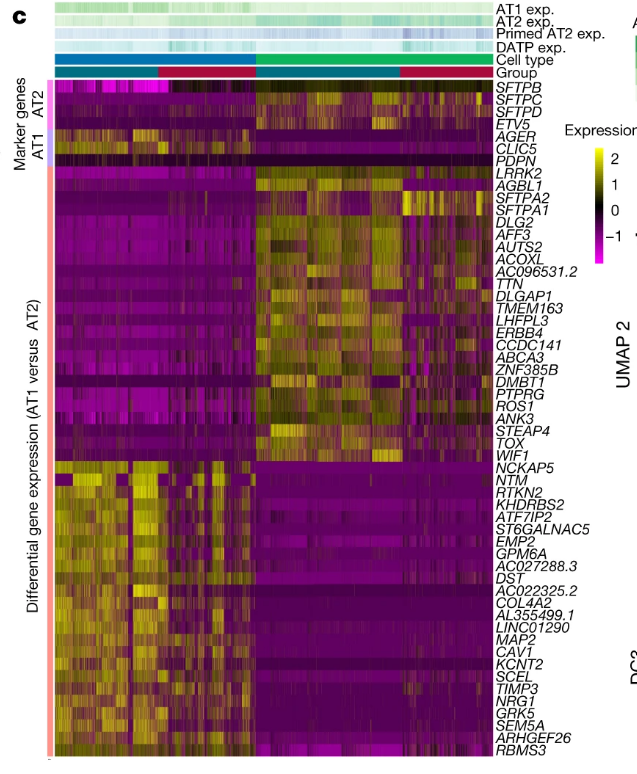

Next we will attempt to recreate Figure 3c. The prinicple behind this heatmap is that we are observing differential gene expression between AT1 and AT2 cell types. We did not annotate at that level of granularity, so instead, we will be conducting differential gene expression between control and COVID infected Alveolar epithelial cells.

In [ ]:
# we will be using the same model from before to conduct Differential Expression Analysis (DEA)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [ ]:
# we will read in this previously saved adata object to obtain the correct dimensions for the features so that the model can work
de_adata = sc.read('data/GSE171524_integrated.h5ad')

In [ ]:
de_adata

AnnData object with n_obs × n_vars = 49656 × 5000
    obs: 'group', 'donor', 'treatment', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p'
    obsm: 'X_scVI'
    layers: 'counts', 'scvi_normalized'

In [ ]:
# copy cell types from original adata object to this one to be used for DEA
de_adata.obs['cell_type'] = adata.obs['cell_type']

In [ ]:
# notice the addition of the `cell_type` column
de_adata.obs

,group,donor,treatment,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,cell_type
GACTGATAGCATACTC-1_13-12-0,L06cov,L06cov,COVID-19,0,1844,3136.0,38.0,1.211735,9.0,0.286990,Myeloid cells
TCGGATAGTCCAGAAG-1_13-12-0,L06cov,L06cov,COVID-19,0,1874,3475.0,4.0,0.115108,50.0,1.438849,B/Plasma cells
AGGTGTTGTGCCTTCT-1_13-12-0,L06cov,L06cov,COVID-19,0,1758,2927.0,0.0,0.000000,48.0,1.639904,Neuronal and Epithelial cells
TCAGCAATCATCTACT-1_13-12-0,L06cov,L06cov,COVID-19,0,622,798.0,5.0,0.626566,16.0,2.005013,Alveolar epithelial cells
GTGGCGTGTTAGTTCG-1_13-12-0,L06cov,L06cov,COVID-19,0,571,710.0,6.0,0.845070,9.0,1.267606,T/NK cells
...,...,...,...,...,...,...,...,...,...,...,...
CAACCTCGTTCAGCTA-1_17-16-26,L10cov,L10cov,COVID-19,26,1180,1868.0,0.0,0.000000,2.0,0.107066,Alveolar epithelial cells
CATACAGCATACTGTG-1_17-16-26,L10cov,L10cov,COVID-19,26,1460,2209.0,0.0,0.000000,0.0,0.000000,Fibroblasts
TCATGGAAGCTACTAC-1_17-16-26,L10cov,L10cov,COVID-19,26,420,517.0,2.0,0.386847,0.0,0.000000,Myeloid cells
TCGCAGGCAACCAACT-1_17-16-26,L10cov,L10cov,COVID-19,26,1270,2096.0,0.0,0.000000,1.0,0.047710,Fibroblasts


In [ ]:
# here we are running the differential expression function from scVI - we indicate our two groups for comparison (the different conditions) and the cell type we want to include in our analysis
scvi_de = model.differential_expression(de_adata, groupby = 'treatment', group1 = 'Control', group2 = 'COVID-19', 
                                        idx1 = [(de_adata.obs['treatment'] == 'Control') & (de_adata.obs['cell_type'] == 'Alveolar epithelial cells')], 
                                        idx2 = [(de_adata.obs['treatment'] == 'COVID-19') & (de_adata.obs['cell_type'] == 'Alveolar epithelial cells')])

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 1/1 [00:14<00:00, 14.22s/it]


In [ ]:
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
GBP4,0.9830,0.0170,4.057395,0.000007,0.000063,0.0,0.25,-3.575428,-3.676643,2.243653,-11.058032,6.438823,0.001159,0.015024,0.001159,0.011931,0.016061,0.255825,True
RGS7,0.9816,0.0184,3.976833,0.000151,0.000021,0.0,0.25,1.761086,2.575469,5.079928,-12.370243,16.839849,0.096721,0.004419,0.061775,0.003756,1.767836,0.079997,True
DACH2,0.9786,0.0214,3.822732,0.000010,0.000059,0.0,0.25,-3.866751,-4.175174,4.261208,-16.093351,13.952140,0.002484,0.013257,0.001491,0.006407,0.062913,0.236754,True
AP002856.2,0.9780,0.0220,3.794467,0.000187,0.000123,0.0,0.25,-1.742821,-1.929298,6.405370,-21.192905,14.193557,0.089268,0.072912,0.053660,0.043084,1.565449,1.234264,True
RPL37A,0.9766,0.0234,3.731341,0.000025,0.000322,0.0,0.25,-3.734262,-3.706578,2.256246,-11.042563,3.075974,0.002650,0.170791,0.001822,0.125718,0.036374,2.889208,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCOA3,0.6556,0.3444,0.643747,0.000454,0.000481,0.0,0.25,-0.064453,-0.070456,0.560717,-2.633613,2.063657,0.307718,0.288555,0.232030,0.221608,5.254887,5.563798,False
IMMP2L,0.6530,0.3470,0.632252,0.001989,0.002084,0.0,0.25,-0.034557,-0.060554,0.566554,-1.879228,2.703927,1.422160,1.418913,0.612123,0.562086,23.927589,24.887709,False
TASP1,0.6344,0.3656,0.551140,0.000325,0.000370,0.0,0.25,-0.165954,-0.164107,0.520089,-2.190805,2.035822,0.223418,0.233760,0.181848,0.183164,3.639756,4.225133,False
UBE2E2,0.6322,0.3678,0.541666,0.001223,0.001310,0.0,0.25,-0.064410,-0.069751,0.518552,-2.018129,1.942581,0.844651,0.739505,0.450977,0.387981,13.633978,13.011155,False


In [ ]:
# filtering out results to obtain signicant ones
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
S100A11,0.9712,0.0288,3.518157,0.000013,0.000143,0.0,0.25,-4.758825,-4.637298,3.854943,-18.083229,10.019440,0.000000,0.045073,0.000000,0.034468,0.000000,0.995117,True
MIR205HG,0.9766,0.0234,3.731341,0.000022,0.000109,0.0,0.25,-4.663562,-4.849425,4.379963,-16.675390,12.079778,0.019709,0.074459,0.011096,0.036898,0.305827,1.581407,True
MELK,0.9722,0.0278,3.554525,0.000001,0.000024,0.0,0.25,-4.463558,-4.390502,3.409580,-16.239960,8.168909,0.000166,0.005745,0.000166,0.005082,0.004787,0.132072,True
TRPC6,0.9754,0.0246,3.680101,0.000017,0.000113,0.0,0.25,-4.340863,-4.530324,3.195952,-14.705158,8.511712,0.010931,0.055236,0.006956,0.028281,0.177733,1.308748,True
MMP1,0.9730,0.0270,3.584547,0.000001,0.000021,0.0,0.25,-4.245872,-4.220149,3.905476,-15.231264,10.324943,0.000828,0.011710,0.000497,0.006186,0.009263,0.191054,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEMA3E,0.9580,0.0420,3.127178,0.000191,0.000013,0.0,0.25,2.334646,1.906137,5.026654,-9.275270,18.281052,0.109970,0.001105,0.067572,0.001105,1.656005,0.008404,True
CSMD1,0.9688,0.0312,3.435640,0.000005,0.000007,0.0,0.25,2.453902,2.894215,4.538780,-12.924119,18.059124,0.000828,0.000884,0.000497,0.000884,0.011026,0.036402,True
IQCN,0.9576,0.0424,3.117282,0.000328,0.000056,0.0,0.25,2.460795,2.503354,1.664349,-4.717428,11.045703,0.195263,0.021653,0.153528,0.015908,3.598148,0.364983,True
FOSB,0.9622,0.0378,3.236913,0.001002,0.000096,0.0,0.25,3.060595,2.973840,2.236943,-4.974063,11.648548,0.550182,0.016571,0.252070,0.011268,10.293012,0.291353,True


In [ ]:
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist() #top 25 and bottom 25 from sorted df

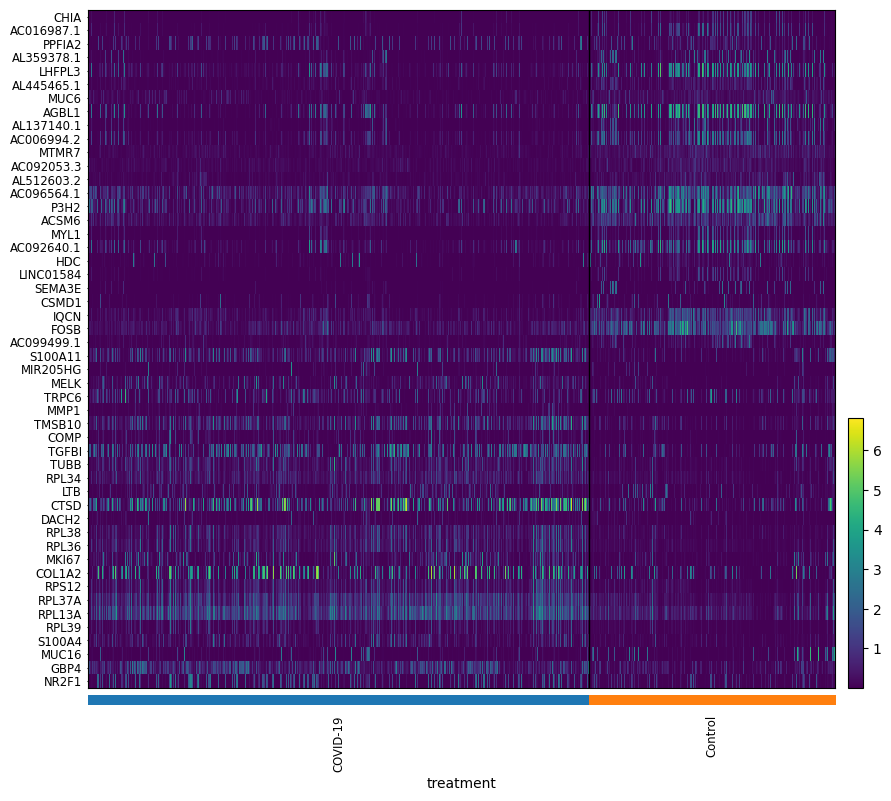

In [ ]:
sc.pl.heatmap(de_adata, genes_to_show, groupby='treatment', swap_axes=True, layer = 'scvi_normalized', log = True)

The heatmap above displays the expression patterns of these differentially expressed genes across the two control conditions in Alveolar epithelial cells. As we can see, the top half of the plot shows that these genes have low expression in the COVID-19 samples but higher expression in the Control samples and vice versa for the bottom half. 

# End of Practise 2